# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divided into the following stages <sup>[[1]](#ref_1)</sup>: 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [178]:
%matplotlib inline
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

matplotlib.style.use('ggplot')

## Reading input data

In [179]:
sqlContext = SQLContext(sc)

telemetry_input_df = sqlContext.read.parquet('data/telemetry')
logs_input_df = sqlContext.read.parquet('data/logs')

telemetry_input_df.printSchema()
logs_input_df.printSchema()

telemetry_entries_count = telemetry_input_df.count()
log_entries_count = logs_input_df.count()

print('Total:\n{0} telemetry entries\n{1}\tlog entries'.format(telemetry_entries_count, log_entries_count))

root
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- machineID: string (nullable = true)
 |-- pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- speed_desired: long (nullable = true)
 |-- temperature: double (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- code: string (nullable = true)
 |-- level: string (nullable = true)
 |-- machineID: string (nullable = true)

Total:
13046220 telemetry entries
526	log entries


## Data exploration

In [180]:
logs_input_df.select('level').distinct().show()

+--------+
|   level|
+--------+
|    INFO|
|CRITICAL|
+--------+



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f039ea314e0>],
      dtype=object)

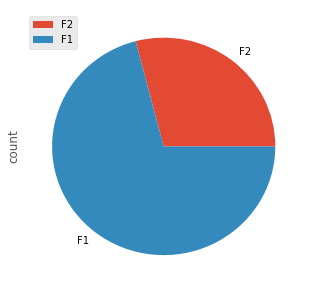

In [181]:
failures_df = logs_input_df.where(F.col('level') == 'CRITICAL')
failures_df.select('code').groupBy('code').agg(F.count(F.lit(1)).alias('count')).toPandas() \
.set_index('code').plot.pie(subplots=True, figsize=(5, 5))

In [182]:
distinct_machines_df = telemetry_input_df.select('machineID').distinct()
machine_count = distinct_machines_df.count()
print('{0} machine(s)'.format(machine_count))

1000 machine(s)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f039e8b6908>]],
      dtype=object)

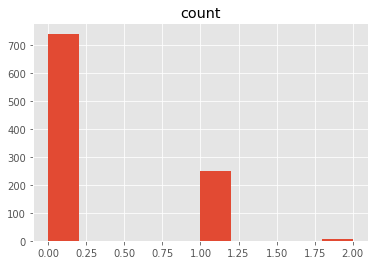

In [183]:
machine_failures_df = distinct_machines_df.join(failures_df, 'machineID', 'left_outer'
                                               ).groupBy('machineID').agg(F.count('code').alias('count'))
machine_failures_df.toPandas().hist()

In [184]:
machineID = machine_failures_df.orderBy(F.desc('count')).first().machineID

machine_sequence_df = telemetry_input_df.where(telemetry_input_df.machineID == machineID).orderBy(telemetry_input_df.timestamp)
#machine_sequence_df.persist(StorageLevel.MEMORY_ONLY)
pdf = machine_sequence_df.toPandas()
pdf.set_index('timestamp', inplace=True)
pdf.describe()

,ambient_pressure,ambient_temperature,pressure,speed,speed_desired,temperature
count,11968.000000,11968.000000,11968.000000,11968.000000,11968.0,11968.000000
mean,100.999734,19.999571,1469.895542,1232.489508,1000.0,145.654403
std,0.057540,0.058093,426.872350,82.169083,0.0,12.077053
min,100.900000,19.900000,217.880000,614.650000,1000.0,22.750000
25%,100.950000,19.950000,1120.655000,1169.570000,1000.0,135.600000
50%,101.000000,20.000000,1435.130000,1180.380000,1000.0,136.890000
75%,101.050000,20.050000,1837.322500,1276.217500,1000.0,153.130000
max,101.100000,20.100000,2718.230000,1768.060000,1000.0,214.940000


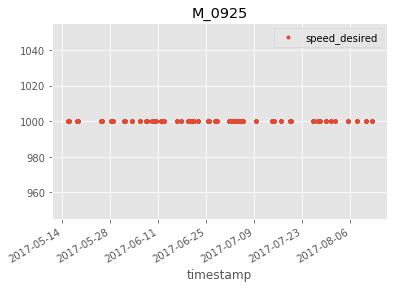

In [185]:
pdf.plot(title=machineID , style=".", y='speed_desired')

## Feature creation

### Operational cycles

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03a073b208>,
      dtype=object)

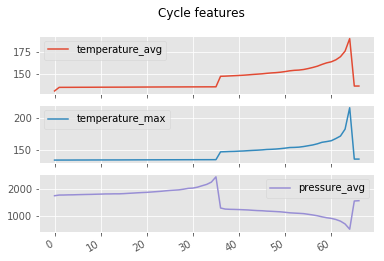

In [186]:
def cycles(df):
    w = Window.partitionBy('machineID').orderBy('timestamp')

    # Difference from the previous record or 0 if this is the first one
    diff = F.coalesce(F.unix_timestamp('timestamp') - F.unix_timestamp(F.lag('timestamp', 1).over(w)), F.lit(0))

    # 0 if diff <= 30, 1 otherwise
    indicator = (diff > 30).cast('integer')

    subgroup = F.sum(indicator).over(w).alias('cycle')

    return df.select("*", subgroup).groupBy('machineID', 'cycle').agg(
        F.avg('speed').alias('speed_avg'),
        F.avg('temperature').alias('temperature_avg'),
        F.max('temperature').alias('temperature_max'),
        F.avg('pressure').alias('pressure_avg'),
        F.max('pressure').alias('pressure_max'),
        F.min('timestamp').alias('cycle_start'),
        F.max('timestamp').alias('cycle_end')
    ).orderBy('cycle')

msdf_cycles = cycles(machine_sequence_df)
msdf_cycles[['temperature_avg', 'temperature_max', 'pressure_avg']].toPandas().plot(subplots=True, title='Cycle features')

In [187]:
cycles_df = cycles(telemetry_input_df)
#print(cycles_df.count())

#cycles_df.select(F.max(F.col('cycle_start'))).show()

### Labeling

In [188]:
w = Window.partitionBy('machineID', 'level').orderBy('timestamp')
diff = F.coalesce(F.lag('timestamp', 1).over(w), F.to_timestamp(F.lit('2000-01-01 00:00:00')))

failure_intervals_df = (failures_df
                .withColumn('last_failure_timestamp', diff)
                .withColumnRenamed('timestamp', 'failure_timestamp')
                .withColumnRenamed('code', 'failure')
                .drop('level'))

failure_intervals_df.where(F.col('machineID') == machineID).toPandas()

,failure_timestamp,failure,machineID,last_failure_timestamp
0,2017-06-22 18:00:48,F2,M_0925,2000-01-01 00:00:00
1,2017-08-07 23:22:40,F1,M_0925,2017-06-22 18:00:48


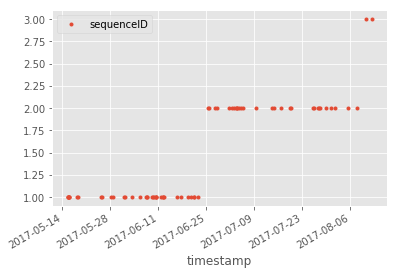

In [189]:
labeled_cycles_df = (cycles_df.join(failure_intervals_df,
                                       (cycles_df.machineID == failure_intervals_df.machineID) &
                                       (cycles_df.cycle_start >= failure_intervals_df.last_failure_timestamp) &
                                       (cycles_df.cycle_end <= failure_intervals_df.failure_timestamp),
                                       'left_outer')
                     .drop(failure_intervals_df.machineID)
                     .drop(cycles_df.cycle_end)
                     .drop(failure_intervals_df.last_failure_timestamp)
                     .withColumnRenamed('cycle_start', 'timestamp')
                     .withColumn(
                         'rul',                         
                          F.when(F.col('failure').isNull(), None).otherwise(
                             F.row_number().over(Window.partitionBy('machineID', 'failure_timestamp')
                                             .orderBy(F.desc('cycle')))))
                     .withColumn(
                         'sequenceID',
                         F.dense_rank().over(Window.partitionBy('machineID')
                                       .orderBy(F.desc('failure'), 'failure_timestamp')))
                     .drop(failure_intervals_df.failure_timestamp))

#labeled_cycles_df.where(F.col('machineID') == 'M_0000').orderBy(F.asc('rul')).toPandas().head()
#failures_df.where(F.col('machineID') == 'M_0000').toPandas().head()
t = labeled_cycles_df.where(F.col('machineID') == machineID).select('timestamp', 'sequenceID', 'failure').toPandas()

t.set_index('timestamp').plot(style='.')

### Augmenting data with lag features

In [190]:
labeled_cycles_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- cycle: long (nullable = true)
 |-- speed_avg: double (nullable = true)
 |-- temperature_avg: double (nullable = true)
 |-- temperature_max: double (nullable = true)
 |-- pressure_avg: double (nullable = true)
 |-- pressure_max: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- failure: string (nullable = true)
 |-- rul: integer (nullable = true)
 |-- sequenceID: integer (nullable = true)



In [191]:
lookback = 5
w = Window.partitionBy('machineID', 'sequenceID').rowsBetween(-lookback, Window.currentRow).orderBy('cycle')

input_columns = ['temperature_avg', 'temperature_max', 'pressure_avg', 'pressure_max']

augmented_labeled_cycles_df = (reduce(lambda _df, ic: _df.withColumn('{0}_avg'.format(ic), F.avg(ic).over(w)), input_columns, labeled_cycles_df)
                               .withColumn('is_valid', F.count(F.lit(1)).over(w) > lookback)
                               .where(F.col('is_valid'))
                               .drop('is_valid'))

## Persisting the labeled feature data set

In [192]:
% rm -rf data/features

augmented_labeled_cycles_df.coalesce(5).write.csv('data/features', header=True)

## References
http://waset.org/publications/10006640/building-a-scalable-telemetry-based-multiclass-predictive-maintenance-model-in-r
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.386.8108&rep=rep1&type=pdf